In [2]:
#import libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
import cv2
from skimage.morphology import skeletonize
from fil_finder import FilFinder2D
import astropy.units as u
import gc
import sklearn.metrics
import timeit
from scipy.interpolate import CubicSpline
gc.collect()


0

C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_8


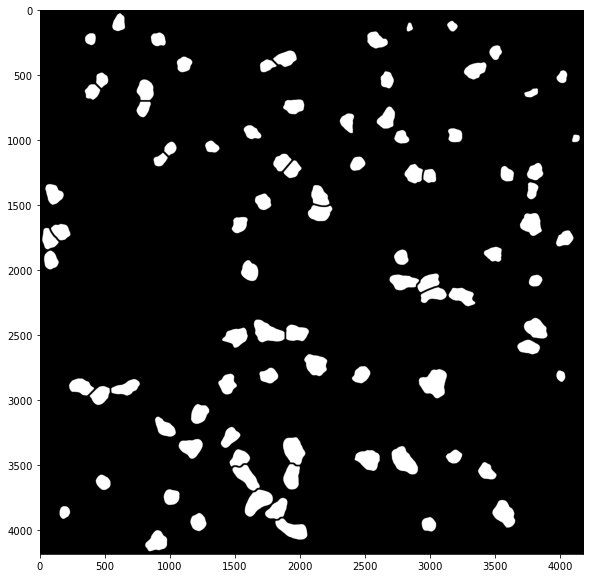

In [12]:
#insert path where images are located
%cd C:\Users\heito\Desktop\Harvard\Sharad Lab\G1\Random_8 
#import images    
img =cv2.imread('final_random_8_masks.tif') #segmented and eroded image (normally from DAPI stain)
img_gene1=cv2.imread('final_random_8_gene1.tif') #image of CDX2 gene expression
img_gene2=cv2.imread('final_random_8_gene2.tif') #image of SOX1 gene expression
img_gene3=cv2.imread('final_random_8_gene3.tif')
plt.figure(figsize=(10,10))
plt.imshow(img)

In [4]:
def get_intersection(hey,initial_pos,epsilon,contour): #function that finds the intersection points and also returns sides of region(normal line)
    # hey contains the points of the skeleton
    x_vec=hey[:,0]
    y_vec=hey[:,1]
    # find line across points of the skeleton centered on initial_pos and +- epsilon
    fit=np.polyfit(x=x_vec[initial_pos-epsilon:initial_pos+epsilon], y=y_vec[initial_pos-epsilon:initial_pos+epsilon], deg=1)
    # find contants of normal line
    m_normal=-1/fit[0]
    b_normal=y_vec[initial_pos]-(m_normal*x_vec[initial_pos])
    
    # if line is too steep, draw straight line and fill in betweens
    if abs(m_normal)>1000:
        y_list=np.linspace(y_vec[initial_pos]-500,y_vec[initial_pos]+500,500000)
        x_list=np.repeat(x_vec[initial_pos], np.shape(y_list)[0])
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    else:
        x_list=np.linspace(x_vec[initial_pos]-500,x_vec[initial_pos]+500,500000)
        y_list=m_normal*x_list+b_normal
        y_list = [int(x) for x in y_list]
        x_list=[int(x) for x in x_list]
    
    coord_list=list(zip(y_list, x_list))
    arr2_2=np.array(coord_list)
    arr1=np.squeeze(contour)
    
    # if points are diagonal, fill in so that points are always 1 away in any direction (makes sure there will be an intersection with contour)
    for hh in range(np.shape(arr2_2)[0]-1):
        if arr2_2[hh+1,0]==arr2_2[hh,0]+1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]+[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        if arr2_2[hh+1,0]==arr2_2[hh,0]-1 and arr2_2[hh+1,1]==arr2_2[hh,1]+1:
            temp=np.append(arr2_2[0:hh+1,:],[arr2_2[hh,:]-[1,0]],axis=0)
            arr2_2=np.append(temp,arr2_2[hh+1:],axis=0)
        
    intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
    
    #if less than 2 points are found, run again with contour expanded by one (very rare case)
    if np.shape(intersection)[0]<2:
        arr1=np.concatenate((arr1,arr1+1),axis=0)
        intersection=np.array([x for x in set(tuple(x) for x in arr2_2) & set(tuple(x) for x in arr1)])
    #if more than 2 intersection points, eliminate duplicates (two points super close to each other) and select closest points to skeleton 
    if np.shape(intersection)[0]>2: #fix this make more general
        dist_1=sklearn.metrics.pairwise_distances(intersection)
        np.fill_diagonal(dist_1, 100)
        dist_1=np.tril(dist_1, k=0)
        dist_1[dist_1==0]=100
        a=np.where(dist_1<5)
        mid_point=np.delete(intersection, a[0][:],0)
        intersection=mid_point
        if np.shape(mid_point)[0]>2:
            repe=np.repeat([[y_vec[initial_pos],x_vec[initial_pos]]],np.shape(mid_point)[0], axis=0)
            dist=np.sqrt((mid_point[:,0]-repe[:,0])**2+(mid_point[:,1]-repe[:,1])**2)
            mins=np.partition(dist,2)[0:2]
            min_id1=np.where(dist==mins[0])
            min_id2=np.where(dist==mins[1])
            intersection=mid_point[[min_id1[0][0],min_id2[0][0]],:]
        
    id1=np.where((arr2_2[:,1]==intersection[0,1]) & (arr2_2[:,0]==intersection[0,0]))
    id2=np.where((arr2_2[:,1]==intersection[1,1]) & (arr2_2[:,0]==intersection[1,0]))
    id_min=np.min([id1[0][0],id2[0][0]])
    id_max=np.max([id1[0][0],id2[0][0]])
    side=coord_list[id_min:id_max]
    
    edge1=np.where((arr1[:,1]==intersection[0,1]) & (arr1[:,0]==intersection[0,0]))
    edge2=np.where((arr1[:,1]==intersection[1,1]) & (arr1[:,0]==intersection[1,0]))
    
    return side, edge1, edge2, arr1

In [5]:
def get_gene_dipole(hey,contour,epsilon,img_gene1,img_gene2): #function that separates organoids into sections and returns gene dipole
    jj=0
    
    #n_segments=20 #number of segments
    #epsilon=np.shape(hey)[0]//n_segments
    
    epsilon=epsilon
    n_segments=np.shape(hey)[0]//epsilon
    initial_pos=epsilon
    gene1=np.empty([1,0])
    gene2=np.empty([1,0])
    position=np.empty([1,0])
    
    # if organoid only has two section aka small skeleton
    if initial_pos+epsilon>(np.shape(hey)[0]):
        mid_point=np.shape(hey)[0]//2
        eps=mid_point-1
        side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
        edges=np.sort([edge1[0][0],edge2[0][0]])
        
        #first half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=arr1[edges[0]:edges[1]]
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'bo')
        
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point-eps/2)
        
         
    
        # second half
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        
        line1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
    
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        region_cont=np.concatenate((line1,side1))
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        
        region = np.argwhere(filled_array == 255)
        #plt.plot(region[:,0],region[:,1],'ro')
        #plt.show()
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, mid_point+eps/2)
       
         
        if np.shape(gene1)[0]==1:
            area_red=gene1[0]
            area_blue=gene2[0]
        else:
            area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
            area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        
        dipole=area_red/(area_red+area_blue)
    
    
    #long skeleton organoid
    n=0
    while (initial_pos+epsilon)<(np.shape(hey)[0]): #iterate through every point on skeleton to get normal lines
        #first section (fix path,sometimes wrong, take shortest path?)
        if n==0:
            mid_point=initial_pos
            eps=epsilon
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            #line1=arr1[edges[0]:edges[1]]
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path1)[0]>np.shape(path2)[0]:
                line1=path2
            else:
                line1=path1
            
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

            region = np.argwhere(filled_array == 255)
            #plt.plot(region[:,0],region[:,1],'go')
            
            segment=np.squeeze(img_gene1[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:,0])*filled_array
            segment[segment == 0] = np.nan
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)  
            
        
        n=n+1
        side1, edge1, edge2, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
        #edge_min_1=np.min([edge1,edge2])
        #edge_max_2=np.max([edge1,edge2])
    
        
        
        
        initial_pos=initial_pos+epsilon
        
        
        side2, edge3, edge4, arr1 = get_intersection(hey,initial_pos,epsilon,contour)
        #edge_min_3=np.min([edge3,edge4])
        #edge_max_4=np.max([edge3,edge4])
        edges=np.sort([edge1[0][0],edge2[0][0],edge3[0][0],edge4[0][0]])
        if edges[0]==edges[1]:
            edges[1]=edges[1]+1
        if edges[2]==edges[3]:
            edges[3]=edges[3]+1
        path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
        path2=arr1[edges[0]:edges[1]]
        if np.shape(path2)[0]>np.shape(path1)[0]:
            line1=path1
        else:
            line1=path2
        path1=np.concatenate((arr1[edges[3]:-1],arr1[0:edges[2]]))
        path2=arr1[edges[2]:edges[3]]
        if np.shape(path2)[0]>np.shape(path1)[0]:
            line2=path1
        else:
            line2=path2
        #line1=arr1[edges[0]:edges[1]]
        #line2=arr1[edges[2]:edges[3]]
        if np.sum(line1[0,:]-line1[-1,:]) <0:
            line1=np.flip(line1,0)
        if np.sum(line2[0,:]-line2[-1,:]) >0:
            line2=np.flip(line2,0)
        side2=np.flip(side2,0)
        region_cont=np.concatenate((line1,side1,line2,side2))
        side_cross=np.array([x for x in set(tuple(x) for x in side1) & set(tuple(x) for x in side2)])
        if np.shape(side_cross)[0]>0:
            line1=np.flip(line1,0)
            line2=np.flip(line2,0)
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))

        region = np.argwhere(filled_array == 255)
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        #plt.imshow(segment)
        gene1=np.append(gene1, np.nanmean(segment)/255)
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        segment[segment == 0] = np.nan
        gene2=np.append(gene2, np.nanmean(segment)/255)
        position=np.append(position, initial_pos-epsilon/2)
        initial_pos=initial_pos
        #plt.imshow(segment)
        #plt.axis([3800,4200,1300,1700])
        #plt.pause(0.05)
        
        #last section
        if n==n_segments-1:
            mid_point=initial_pos-epsilon//4
            eps=epsilon//4
            side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)
            edges=np.sort([edge1[0][0],edge2[0][0]])
            
            if edges[0]==edges[1]:
                edges[1]=edges[1]+1
        
            path1=np.concatenate((arr1[edges[1]:-1],arr1[0:edges[0]]))
            path2=arr1[edges[0]:edges[1]]
            if np.shape(path2)[0]>np.shape(path1)[0]:
                line1=path1
            else:
                line1=path2
    
            if np.sum(line1[0,:]-line1[-1,:]) <0:
                line1=np.flip(line1,0)
            region_cont=np.concatenate((line1,side1))
            im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
            filled_array = cv2.fillPoly(im_zer, pts =[region_cont], color=(255))
            filled_array[filled_array == 0] = np.nan
            region = np.argwhere(filled_array == 255)
            
            segment=np.squeeze(img_gene1[:,:,0])*filled_array
            
            gene1=np.append(gene1, np.nanmean(segment)/255)
            segment=np.squeeze(img_gene2[:,:,0])*filled_array
            
            gene2=np.append(gene2, np.nanmean(segment)/255)
            position=np.append(position, mid_point-eps/2)
             
    
    #gene_1_mean=np.mean(np.squeeze(img_gene1[:,:,0]))/np.max(gene1)
    #gene_2_mean=np.mean(np.squeeze(img_gene2[:,:,0]))/np.max(gene2)
    
   # print(dip_1)
    #print(dip_2)
    
    if np.shape(gene1)[0]==1:
        dip_1=0
        dip_2=0    
        dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)
    else:
        #area_red = np.trapz(gene1/np.max(gene1), dx=position[1]-position[0])
        #area_blue = np.trapz(gene2/np.max(gene1), dx=position[1]-position[0])
        dip_1=gene1/np.max(np.squeeze(img_gene1[:,:,0]))*(position-np.shape(hey)[0]/2)
        dip_2=gene2/np.max(np.squeeze(img_gene2[:,:,0]))*(position-np.shape(hey)[0]/2) 
        #dip_2=0
        dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)
        
        #if np.max(gene1/np.max(np.squeeze(img_gene1[:,:,0])))<0.03 or np.max(gene2)/np.max(np.squeeze(img_gene2[:,:,0]))<0.03:
         #   dipole=np.array([0])
        #print(gene1/np.max(np.squeeze(img_gene1[:,:,0])))
        #print(gene2/np.max(np.squeeze(img_gene2[:,:,0])))
        #print(position)
        #dipole=np.abs(np.sum(dip_1))/(np.shape(hey)[0]/2)
    #yp=np.linspace(0, 1, 1000)
    #plt.plot(position, gene1/np.max(gene1),'r.')
    #plt.plot(position, gene2/np.max(gene2),'b.')
    #plt.plot(yp,fit_1(yp),'r--')
    #plt.plot(yp,fit_2(yp),'b--')
    #plt.axis([0, position[-1]+50, 0, 1])
    #plt.show()
    if dipole.size == 0:
        dipole=0
    return dipole

In [13]:
# Grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find Canny edges
edged = cv2.Canny(img, 30, 200)

#Find contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

#Initialize arrays
start = timeit.timeit()
dipole_list=np.empty([1,0])
elongation_list=np.empty([1,0])
aspect_ratio_list=np.empty([1,0])
meso_list=np.empty([1,0])
centroid_list=[[1,1], [1,1]]
true_org=np.empty([1,0])
mean_m_list=np.empty([1,0])

#Check if contours are organoids
for ii in range(np.shape(contours)[0]):
    
    M = cv2.moments(contours[ii])
    if M["m00"] == 0:
        true_org=np.append(true_org,0)
    else:
        true_org=np.append(true_org,1)


for ii in range(np.shape(contours)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        # diff of mean intensity 
        filled_array[filled_array == 0] = np.nan
        segment=np.squeeze(img_gene1[:,:,0])*filled_array
        mean1=np.nanmean(segment)/(255*np.max(np.squeeze(img_gene1[:,:,0])))
        
        segment=np.squeeze(img_gene2[:,:,0])*filled_array
        mean2=np.nanmean(segment)/(255*np.max(np.squeeze(img_gene2[:,:,0])))
        
        meanm=mean1-mean2
        
        obj = np.argwhere(filled_array == 255)
        
        # average mesoderm intensity
        meso=np.nanmean(filled_array*np.squeeze(img_gene3[:,:,0])/np.max(np.squeeze(img_gene3[:,:,0])))
        

        bin_arr = np.where(filled_array > 0, 1, 0)
    
        image = bin_arr

    # perform skeletonization
    
        skeleton1 = skeletonize(image)


        binSkel = skeleton1*1
        skelObj = np.argwhere(binSkel == 1)

        fil = FilFinder2D(binSkel, distance=250 * u.pc, mask=skeleton1)
        fil.preprocess_image(flatten_percent=85)
        fil.create_mask(border_masking=True, verbose=False,
        use_existing_mask=True)
        fil.medskel(verbose=False)
        fil.analyze_skeletons(branch_thresh=40* u.pix, skel_thresh=5 * u.pix, prune_criteria='length')
        skeleton_length=fil.lengths()
        # how many tails the organoid has
        numb=fil.branch_properties['number']
        
        

        # find aspect ratio
        x,y,w,h = cv2.boundingRect(contours[ii])
        aspect_ratio = float(w)/h
        # find centroid
        M = cv2.moments(contours[ii])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroid=np.array([cY,cX])
        
        # order skeleton
        hey_1 = np.argwhere(fil.skeleton_longpath==1)
        if hey_1.size==0:
            hey_1=skelObj
        im_zer = np.zeros( (img.shape[0],img.shape[1]) )
        skele_im=im_zer
        skele_im[hey_1[:,0],hey_1[:,1]]=255
        n=0
        ma=np.array([1,1,1])
        ok2=0
        while ok2==0:
            
            in_x=hey_1[n,0]
            in_y=hey_1[n,1]
            ma=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
            n=n+1
            if np.sum(ma)<255*3:
                ok2=1
        skeleton=np.array([[0,1],[in_x, in_y]])
        ok=0
        x_prev=1
        y_prev=1
        neighbors=skele_im[in_x-1:in_x+2,in_y-1:in_y+2]
        center_y=in_y
        center_x=in_x
        n=0
        while ok==0:
        
        
            neighbors[x_prev,y_prev]=0
            neighbors[1,1]=0
            res=np.where(neighbors==255)
            if res[0].size==0 :
         
                break
        
            y_next=res[1]
            x_next=res[0]
            skeleton=np.append(skeleton, [[x_next[0]-1+center_x, y_next[0]-1+center_y]], axis=0)
            y_prev=2-y_next[0]
            x_prev=2-x_next[0]
        
            center_y=center_y+y_next[0]-1
            center_x=center_x+x_next[0]-1
        
            neighbors=skele_im[-1+center_x:2+center_x,-1+center_y:2+center_y]
        

        skeleton=np.delete(skeleton, 0,0)
        hey=skeleton
        
        epsilon=20
        # If skeleton is small, extend a bit
        if np.shape(hey)[0]<6:
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
            hey=np.concatenate(([[hey[0,0]-1,hey[0,1]-1]],hey,[[hey[-1,0]+1,hey[-1,1]+1]]))
            
        # Elongation is equal to skeleton length
        elongation=np.shape(hey)[0]
        
        # Get dipole
        dipole=get_gene_dipole(hey,contours[ii],epsilon,img_gene1,img_gene2)
        
        # Append values to lists
        dipole_list=np.append(dipole_list,dipole)
        elongation_list=np.append(elongation_list,elongation)
        aspect_ratio_list=np.append(aspect_ratio_list,aspect_ratio)
        meso_list=np.append(meso_list,meso)
        centroid_list=np.append(centroid_list,[centroid],axis=0)
        mean_m_list=np.append(mean_m_list,meanm)
        print('dipole gene=',dipole)
        print('elongation=',elongation)
        print('aspect ratio=',aspect_ratio)
        print('centroid=',centroid)
        print('mesoderm marker=',meso)
        print('mean=',meanm)
#plt.show()
centroid_list=np.delete(centroid_list, [0,1],0)
end = timeit.timeit()
print(end - start)

C:\Users\heito\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\l

dipole gene= 0.014962536683509987
elongation= 119
aspect ratio= 1.0368098159509203
centroid= [4085  897]
mesoderm marker= 7.789566897440026
mean= 0.05451323447857112
dipole gene= 0.07316215256205169
elongation= 173
aspect ratio= 1.5
centroid= [3992 1938]
mesoderm marker= 4.518132764462291
mean= 0.03735496289953636


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0215764259616005
elongation= 7
aspect ratio= 1.0
centroid= [3952 2987]
mesoderm marker= 11.391264320785597
mean= 0.05578106447161516
dipole gene= 0.0042752235410566325
elongation= 27
aspect ratio= 0.8857142857142857
centroid= [3935 1216]
mesoderm marker= 8.363521715141484
mean= 0.05131344884450194


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0034339402041299407
elongation= 30
aspect ratio= 0.8367346938775511
centroid= [3858  188]
mesoderm marker= 9.657518857326272
mean= 0.05341445838486252


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.055698645355955534
elongation= 154
aspect ratio= 0.8309859154929577
centroid= [3870 3567]
mesoderm marker= 7.374669749009247
mean= 0.05671526536638434


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-5-2f7728f72c98>:1

dipole gene= 0.0027024253596754787
elongation= 124
aspect ratio= 1.0552147239263803
centroid= [3837 1823]
mesoderm marker= 5.05635309350898
mean= 0.02285462290529002


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.09875776845355341
elongation= 145
aspect ratio= 1.0285714285714285
centroid= [3779 1673]
mesoderm marker= 5.269536716505855
mean= 0.01662420731716123


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.004989184955584591
elongation= 18
aspect ratio= 1.0082644628099173
centroid= [3742 1010]
mesoderm marker= 9.957691018766756
mean= 0.0540607094044052
dipole gene= 0.012735782370106797
elongation= 20
aspect ratio= 0.9661016949152542
centroid= [3629  485]
mesoderm marker= 10.561337914308812
mean= 0.06383288157623598
dipole gene= 0.13723472293819453
elongation= 183
aspect ratio= 1.0552763819095476
centroid= [3588 1587]
mesoderm marker= 4.915645176382521
mean= 0.021290756407363172


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0015477961954785445
elongation= 121
aspect ratio= 0.6564102564102564
centroid= [3588 1934]
mesoderm marker= 4.746181087795338
mean= 0.034951376819029316


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.004833952078790013
elongation= 95
aspect ratio= 1.0751879699248121
centroid= [3547 3433]
mesoderm marker= 11.009920793663493
mean= 0.0691958101746179


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.024638223779277824
elongation= 140
aspect ratio= 1.2125
centroid= [3454 2522]
mesoderm marker= 7.392240790492236
mean= 0.055384277475846226


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03295624139751238
elongation= 61
aspect ratio= 1.1666666666666667
centroid= [3432 3183]
mesoderm marker= 10.037661367758455
mean= 0.05798151971767049


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06872099753408602
elongation= 105
aspect ratio= 1.196969696969697
centroid= [3443 1534]
mesoderm marker= 5.577782568082202
mean= 0.040690677363134656


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04090646070445046
elongation= 158
aspect ratio= 0.9269406392694064
centroid= [3464 2797]
mesoderm marker= 5.184125269978401
mean= 0.049414023348720346


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.01096622518225422
elongation= 106
aspect ratio= 1.2171052631578947
centroid= [3361 1161]
mesoderm marker= 4.9488103821196825
mean= 0.04661482473306554


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02257205269347121
elongation= 131
aspect ratio= 0.8113207547169812
centroid= [3382 1950]
mesoderm marker= 5.739194537130442
mean= 0.03902359422856595


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.027472730041810788
elongation= 93
aspect ratio= 0.9320987654320988
centroid= [3283 1460]
mesoderm marker= 5.045799381848834
mean= 0.04831633693095107


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.024306798687881093
elongation= 127
aspect ratio= 1.0324675324675325
centroid= [3209  959]
mesoderm marker= 8.025468556128779
mean= 0.08125506586099471


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0002792116718823483
elongation= 46
aspect ratio= 0.9150326797385621
centroid= [3102 1224]
mesoderm marker= 5.043127540650406
mean= 0.04985291626813328
dipole gene= 0.0208680338535632
elongation= 66
aspect ratio= 1.0616438356164384
centroid= [2959  463]
mesoderm marker= 4.32302110817942
mean= 0.043731310466138956


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-5-2f7728f72c98>:1

dipole gene= 0.0052090570969339865
elongation= 169
aspect ratio= 1.71875
centroid= [2902  663]
mesoderm marker= 5.5197453730991395
mean= 0.050970568588156705


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.004694161914124045
elongation= 126
aspect ratio= 1.4621212121212122
centroid= [2894  314]
mesoderm marker= 7.643020594965675
mean= 0.053858464115564664


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.012387987169468345
elongation= 97
aspect ratio= 0.9
centroid= [2874 1441]
mesoderm marker= 9.148189233278956
mean= 0.06787371653392188


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.009761350730851182
elongation= 38
aspect ratio= 0.7840909090909091
centroid= [2811 4001]
mesoderm marker= 8.195947402457426
mean= 0.06019214756391886
dipole gene= 0.0154195007314345
elongation= 155
aspect ratio= 0.96
centroid= [2867 3029]
mesoderm marker= 6.888787519386917
mean= 0.044769303883704134


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.036371074345914856
elongation= 67
aspect ratio= 1.1983471074380165
centroid= [2810 1758]
mesoderm marker= 10.803912213740459
mean= 0.0684582834406027


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.029075396267846457
elongation= 66
aspect ratio= 1.0757575757575757
centroid= [2802 2469]
mesoderm marker= 13.838029241547366
mean= 0.06259832291125406


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03557863811702938
elongation= 81
aspect ratio= 1.047337278106509
centroid= [2725 2119]
mesoderm marker= 6.9633891213389125
mean= 0.05782940427398901


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.018017405555720734
elongation= 102
aspect ratio= 1.5486725663716814
centroid= [2590 3755]
mesoderm marker= 8.04386832438542
mean= 0.07586265644997756
dipole gene= 0.010443815864292697
elongation= 159
aspect ratio= 1.270967741935484
centroid= [2511 1507]
mesoderm marker= 10.205393976897689
mean= 0.05635252863521646


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.01413221971301652
elongation= 96
aspect ratio= 1.3779527559055118
centroid= [2482 1970]
mesoderm marker= 4.879979570990807
mean= 0.04393750236446865


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-5-2f7728f72c98>:1

dipole gene= 0.05430921999283675
elongation= 189
aspect ratio= 1.3485714285714285
centroid= [2475 1749]
mesoderm marker= 5.511361557320063
mean= 0.04292237148070103


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.020797927640332173
elongation= 98
aspect ratio= 1.1383647798742138
centroid= [2448 3810]
mesoderm marker= 7.609074697840301
mean= 0.07009599956487449


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.10647914515791684
elongation= 191
aspect ratio= 1.4507042253521127
centroid= [2198 3244]
mesoderm marker= 5.578545493378898
mean= 0.05447353653122933


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.021983447226065083
elongation= 138
aspect ratio= 1.6528925619834711
centroid= [2188 3024]
mesoderm marker= 4.876661840200079
mean= 0.034342116470123654


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0019355736792659394
elongation= 29
aspect ratio= 1.1555555555555554
centroid= [2079 3807]
mesoderm marker= 9.653376729048006
mean= 0.04509910283614395
dipole gene= 0.051049520219355674
elongation= 176
aspect ratio= 1.860655737704918
centroid= [2088 2790]
mesoderm marker= 6.049557247164828
mean= 0.05222523787620792


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.016139593718284023
elongation= 129
aspect ratio= 1.1805555555555556
centroid= [2092 2986]
mesoderm marker= 5.495291290511139
mean= 0.04400628082628778


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04370657398364148
elongation= 83
aspect ratio= 0.8209876543209876
centroid= [2006 1611]
mesoderm marker= 17.2564282524086
mean= 0.06946978880877944


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.017705800843504763
elongation= 35
aspect ratio= 0.7687074829931972
centroid= [1922   83]
mesoderm marker= 8.032001326479854
mean= 0.05971077537299117
dipole gene= 0.014281092054323364
elongation= 28
aspect ratio= 0.9491525423728814
centroid= [1900 2776]
mesoderm marker= 14.699259407526021
mean= 0.0687014317336222


<ipython-input-5-2f7728f72c98>:185: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)


dipole gene= 0.02934321967606375
elongation= 75
aspect ratio= 1.1810344827586208
centroid= [1875 3486]
mesoderm marker= 10.224460552933243
mean= 0.06515509103169251


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0008872194771765667
elongation= 82
aspect ratio= 1.0806451612903225
centroid= [1757 4032]
mesoderm marker= 7.832846589933001
mean= 0.06644047414533585


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.011415010371409847
elongation= 106
aspect ratio= 0.7636363636363637
centroid= [1762   68]
mesoderm marker= 5.638639330415419
mean= 0.04503420042669605


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.011692656164576135
elongation= 111
aspect ratio= 1.1811023622047243
centroid= [1702  161]
mesoderm marker= 5.924983104302771
mean= 0.04668277463422104


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.024010999484234893
elongation= 53
aspect ratio= 0.984
centroid= [1648 1533]
mesoderm marker= 13.739538055058382
mean= 0.06452439323978121


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.01893944453993493
elongation= 115
aspect ratio= 0.9602272727272727
centroid= [1644 3775]
mesoderm marker= 6.05958891193664
mean= 0.053741038184083746


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04166841513468346
elongation= 142
aspect ratio= 1.504
centroid= [1559 2149]
mesoderm marker= 5.5562246670526925
mean= 0.044972126661898114


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0018987164962809377
elongation= 45
aspect ratio= 0.984375
centroid= [1473 1715]
mesoderm marker= 9.52715954634604
mean= 0.0698702675408016


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.009168514412040418
elongation= 134
aspect ratio= 0.9038461538461539
centroid= [1429 2147]
mesoderm marker= 6.453094067309534
mean= 0.05833943769729617


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0659440402571254
elongation= 81
aspect ratio= 0.8930817610062893
centroid= [1414  105]
mesoderm marker= 11.870801202457194
mean= 0.06567179479294005


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.03122407928331974
elongation= 66
aspect ratio= 0.6717557251908397
centroid= [1387 3782]
mesoderm marker= 6.955056179775281
mean= 0.06598484431225674


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.008339531915585464
elongation= 24
aspect ratio= 0.9252336448598131
centroid= [1274 2994]
mesoderm marker= 11.009151223976207
mean= 0.07274056728616864
dipole gene= 0.01557714822821913
elongation= 44
aspect ratio= 0.865546218487395
centroid= [1261 3586]
mesoderm marker= 9.59472295514512
mean= 0.07535433804128512


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.026255070944833564
elongation= 96
aspect ratio= 0.9403973509933775
centroid= [1259 2873]
mesoderm marker= 9.106834460137893
mean= 0.06152024770012429


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.04900859182447635
elongation= 79
aspect ratio= 0.9402985074626866
centroid= [1244 3805]
mesoderm marker= 7.1429872495446265
mean= 0.06829334813905691


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.00968065008394439
elongation= 88
aspect ratio= 1.0145985401459854
centroid= [1228 1942]
mesoderm marker= 8.317126974322774
mean= 0.05318962668452186


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0
elongation= 40
aspect ratio= 1.0825688073394495
centroid= [1181 2439]
mesoderm marker= 11.843528183716074
mean= 0.05202648491546932
dipole gene= 0.010945252528462159
elongation= 102
aspect ratio= 1.0291970802919708
centroid= [1167 1857]
mesoderm marker= 7.9753898635477585
mean= 0.0531523525589573


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0009237925628378546
elongation= 38
aspect ratio= 1.0480769230769231
centroid= [1152  924]
mesoderm marker= 6.979630635524171
mean= 0.04138362569362346
dipole gene= 0.004567767386090472
elongation= 26
aspect ratio= 0.8878504672897196
centroid= [1063 1001]
mesoderm marker= 12.072803935347856
mean= 0.041974563542915413


<ipython-input-5-2f7728f72c98>:185: RankWarning: Polyfit may be poorly conditioned
  side1, edge1, edge2, arr1 = get_intersection(hey,mid_point,eps,contour)


dipole gene= 0.018185595383306902
elongation= 42
aspect ratio= 1.1956521739130435
centroid= [1051 1320]
mesoderm marker= 11.06474820143885
mean= 0.04575039191732074


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.015075591387834117
elongation= 18
aspect ratio= 1.0172413793103448
centroid= [ 986 4117]
mesoderm marker= 10.40495575221239
mean= 0.05202915148360229


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02123487313743591
elongation= 53
aspect ratio= 1.1057692307692308
centroid= [ 977 2777]
mesoderm marker= 9.70786904078116
mean= 0.06696106587379352


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0067651475827404
elongation= 45
aspect ratio= 1.0092592592592593
centroid= [ 962 3189]
mesoderm marker= 8.878066157760815
mean= 0.05005817492391359


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.06015564276293221
elongation= 80
aspect ratio= 1.2592592592592593
centroid= [ 940 1628]
mesoderm marker= 6.411525490974013
mean= 0.06093251027846171


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.007347533077516825
elongation= 114
aspect ratio= 0.7236842105263158
centroid= [ 862 2363]
mesoderm marker= 10.056498650648559
mean= 0.05252996994044419


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-5-2f7728f72c98>:1

dipole gene= 0.023145175066551546
elongation= 136
aspect ratio= 0.8187134502923976
centroid= [ 834 2665]
mesoderm marker= 7.313227848101266
mean= 0.05975564656242244


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02065202823248689
elongation= 75
aspect ratio= 0.9166666666666666
centroid= [758 795]
mesoderm marker= 8.226873168689828
mean= 0.055637973062812415


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02290087134802816
elongation= 96
aspect ratio= 1.4173913043478261
centroid= [ 739 1951]
mesoderm marker= 12.11580920641533
mean= 0.07590698016344632


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.006964382422645715
elongation= 72
aspect ratio= 1.5
centroid= [ 638 3777]
mesoderm marker= 3.5645358306188926
mean= 0.046843264993293734


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.017702373914689942
elongation= 55
aspect ratio= 0.9915966386554622
centroid= [628 401]
mesoderm marker= 9.402221340737803
mean= 0.05150422723631301


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.021088121286412406
elongation= 71
aspect ratio= 0.8301886792452831
centroid= [615 810]
mesoderm marker= 5.973241075255649
mean= 0.057202289402687775
dipole gene= 0.015346414764889613
elongation= 55
aspect ratio= 0.788135593220339
centroid= [536 475]
mesoderm marker= 8.036284289276807
mean= 0.05193633563150945
dipole gene= 0.02346030997092743
elongation= 86
aspect ratio= 0.7709923664122137
centroid= [ 537 2666]
mesoderm marker= 11.003778462762256
mean= 0.0567658464399979


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-5-2f7728f72c98>:1

dipole gene= 0.00806428506733935
elongation= 47
aspect ratio= 0.8469387755102041
centroid= [ 513 4012]
mesoderm marker= 9.221679851876788
mean= 0.06877894062859953


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")
<ipython-input-5-2f7728f72c98>:1

dipole gene= 0.04435336146594561
elongation= 111
aspect ratio= 1.3082706766917294
centroid= [ 463 3344]
mesoderm marker= 9.152967311964456
mean= 0.07018935787580662


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0007591705454964204
elongation= 91
aspect ratio= 1.292929292929293
centroid= [ 427 1744]
mesoderm marker= 6.522142857142857
mean= 0.04130485527544351


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.0005225066326701267
elongation= 33
aspect ratio= 0.9834710743801653
centroid= [ 417 1107]
mesoderm marker= 8.972553033122441
mean= 0.061946591066646225
dipole gene= 0.005239856023660991
elongation= 137
aspect ratio= 1.4365079365079365
centroid= [ 372 1888]
mesoderm marker= 5.397206777866031
mean= 0.04859780819926595


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.030378406057022002
elongation= 56
aspect ratio= 0.8584070796460177
centroid= [ 324 3500]
mesoderm marker= 9.078341599898257
mean= 0.06229149678439353


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.009634770121979804
elongation= 15
aspect ratio= 0.9021739130434783
centroid= [222 388]
mesoderm marker= 9.176209279368214
mean= 0.04706204956480782
dipole gene= 0.0026881806678749646
elongation= 22
aspect ratio= 1.0754716981132075
centroid= [226 908]
mesoderm marker= 12.415663900414938
mean= 0.07056138638027826
dipole gene= 0.021778870820566974
elongation= 99
aspect ratio= 1.1893939393939394
centroid= [ 233 2584]
mesoderm marker= 7.051774734488541
mean= 0.05637939916044675


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.011617021233724613
elongation= 41
aspect ratio= 0.7101449275362319
centroid= [ 132 2839]
mesoderm marker= 6.755785123966942
mean= 0.04204342894182467


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.007481582016239743
elongation= 30
aspect ratio= 0.9878048780487805
centroid= [ 123 3168]
mesoderm marker= 7.132759001546278
mean= 0.052038964470259054


C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:138: UserWarning: No beam width given. Using 0 pixels.
  warnings.warn("No beam width given. Using 0 pixels.")
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\astropy\units\quantity.py:479: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filfinder2D.py:288: UserWarning: Using inputted mask. Skipping creation of anew mask.
  warnings.warn("Using inputted mask. Skipping creation of a"
C:\Users\heito\anaconda3\lib\site-packages\fil_finder\filament.py:326: UserWarning: Graph pruning reached max iterations.
  warnings.warn("Graph pruning reached max iterations.")


dipole gene= 0.02894023792704302
elongation= 61
aspect ratio= 0.7101449275362319
centroid= [ 99 606]
mesoderm marker= 9.959416233506598
mean= 0.06274784203965474
0.0006252999992284458


In [14]:
# save data, there is probably a better way to do this, but I am not sure
d = {'Dipole': dipole_list, 'Elongation': elongation_list, 'Aspect_Ratio': aspect_ratio_list, 'Centroid_x':centroid_list[:,1] , 'Centroid_y': centroid_list[:,0], 'Diff_of_means': mean_m_list}
df = pd.DataFrame(data=d)
# name of the table
df.to_csv('exported_metrics_random_8.csv', index=False)
df

,Dipole,Elongation,Aspect_Ratio,Centroid_x,Centroid_y,Diff_of_means
0,0.014963,119.0,1.036810,4085,897,0.054513
1,0.073162,173.0,1.500000,3992,1938,0.037355
2,0.021576,7.0,1.000000,3952,2987,0.055781
3,0.004275,27.0,0.885714,3935,1216,0.051313
4,0.003434,30.0,0.836735,3858,188,0.053414
...,...,...,...,...,...,...
85,0.002688,22.0,1.075472,226,908,0.070561
86,0.021779,99.0,1.189394,233,2584,0.056379
87,0.011617,41.0,0.710145,132,2839,0.042043
88,0.007482,30.0,0.987805,123,3168,0.052039


# end of code bellow is just debugging / visualization stuff

<ipython-input-15-b1a73f9888d4>:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color = 'k', alpha = 1)


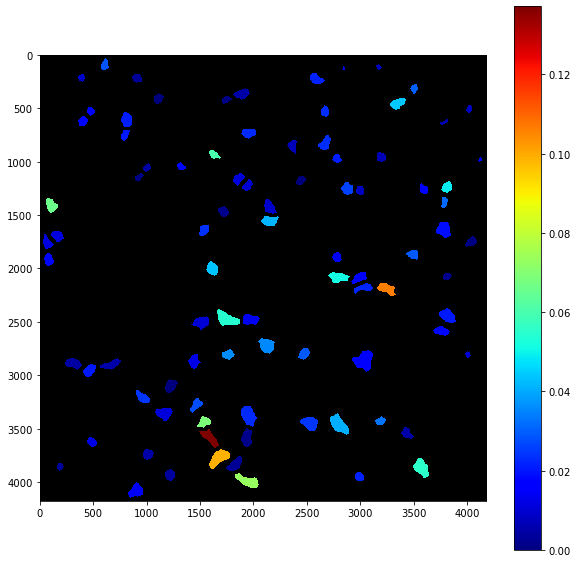

In [15]:
# visualize dipole moment

im_color=np.zeros( (img.shape[0],img.shape[1]) )
 
im_color[im_color==0]=np.nan
for ii in range(np.shape(dipole_list)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        obj = np.argwhere(filled_array == 255)
        im_color[obj[:,0],obj[:,1]]=dipole_list[ii]
plt.figure(figsize=(10,10))

cmap = plt.cm.get_cmap("jet")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(im_color, cmap=cmap)

plt.colorbar(im)




<ipython-input-9-6c82dc197039>:17: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color = 'k', alpha = 1)


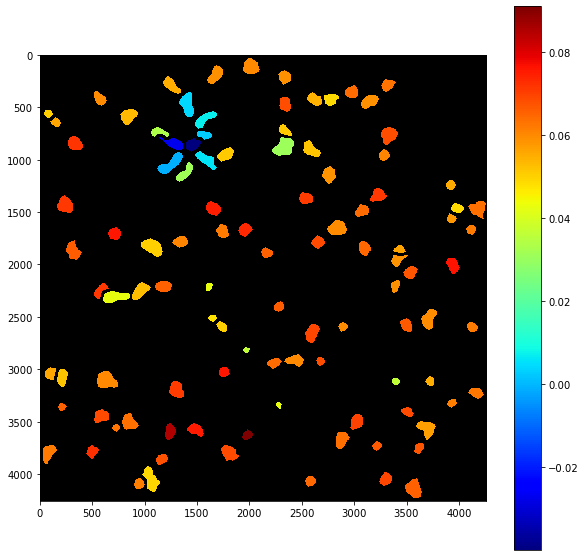

In [9]:
# visualize mean metric

im_color=np.zeros( (img.shape[0],img.shape[1]) )
 
im_color[im_color==0]=np.nan
for ii in range(np.shape(dipole_list)[0]):
    
    if true_org[ii]==1:
        im_zer = np.zeros( (img.shape[0],img.shape[1]) ) # create a single channel 200x200 pixel black image
        filled_array = cv2.fillPoly(im_zer, pts =[contours[ii]], color=(255))
        
        obj = np.argwhere(filled_array == 255)
        im_color[obj[:,0],obj[:,1]]=mean_m_list[ii]
plt.figure(figsize=(10,10))

cmap = plt.cm.get_cmap("jet")
cmap.set_bad(color = 'k', alpha = 1)
im = plt.imshow(im_color, cmap=cmap)

plt.colorbar(im)

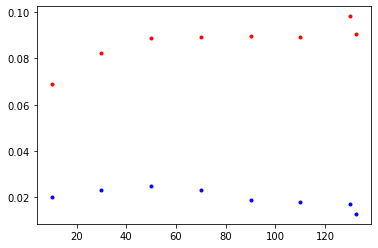

70.5

In [161]:
gene1=[0.06886484, 0.08211693, 0.08898413, 0.08910554, 0.08972873, 0.08920459,0.09819136, 0.09031054]
gene2=[0.02023379, 0.02307213, 0.02497011, 0.02308543, 0.0188759,  0.01797035, 0.01734052, 0.01285602]
pos=[ 10,   30,   50,   70,   90,  110,  130,  132.5]
plt.plot(pos,gene1,'r.')
plt.plot(pos,gene2,'b.')
plt.show()
np.shape(hey)[0]/2

In [ ]:
gene1=0
dip_1=gene1/np.max(gene1)*(position-np.shape(hey)[0]/2)
dip_2=gene2/np.max(gene2)*(position-np.shape(hey)[0]/2)    
dipole=np.abs(np.sum(dip_1)-np.sum(dip_2))/(np.shape(hey)[0]/2)

In [46]:
mean_m_list=np.empty([0,0])
[meanm]
mean_m_list=np.append(mean_m_list,meanm,axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 0 dimension(s)

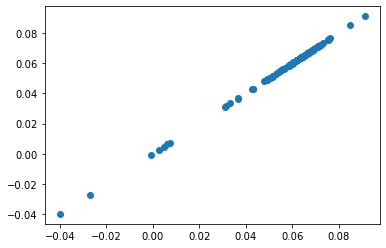

In [53]:
plt.scatter(mean_m_list,mean_m_list)
plt.show()

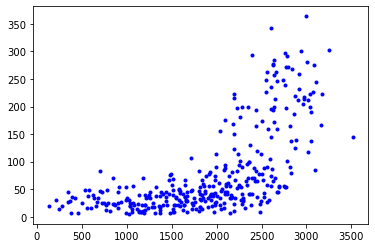

In [133]:
plt.plot(dist,elongation_list,'b.')

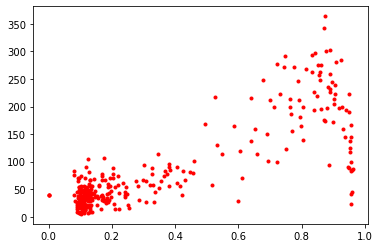

In [134]:
plt.plot(dipole_list,elongation_list,'r.')

(282.25, 6018.75, 267.75, 6257.25)

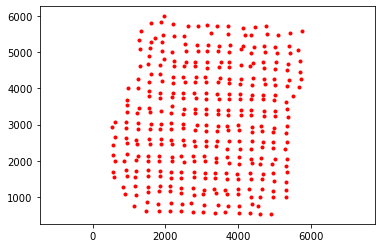

In [138]:
plt.plot(centroid_list[:,1],centroid_list[:,0],'r.')
plt.axis('equal')